# TFM: Predicción de Tiempos de Producción mediante Aprendizaje Automático

**Autor:** Stephan Richter  
**Tutora:** Lorena Polo Navarro  
**Universidad:** UOC - Máster en Ciencia de Datos  
**Fecha:** Diciembre 2025

---

## Notebook 3/3: Validación y Sistema de Predicción

## Objetivo

Este notebook carga los modelos entrenados en el Notebook 2 y:
1. Valida el rendimiento con análisis detallado de errores
2. Implementa la función de predicción para producción
3. Genera visualizaciones finales para el TFM
4. Documenta recomendaciones de uso

## 1. Importaciones y Configuración

In [2]:
# =============================================================================
# 1. IMPORTS Y CONFIGURACION
# =============================================================================

import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports completados")

Imports completados


## 2. Configuración de Columnas y Parámetros

In [6]:
# =============================================================================
# 2. CONFIGURACION - CONSISTENTE CON NOTEBOOK 2
# =============================================================================

# Paths de modelos exportados
MODEL_PATH = Path('modelos_exportados')
DATA_PATH = MODEL_PATH / 'datos'

# Columnas DATOS REALES
COL_MATERIAL_REAL = 'MaterialTruTops'
COL_TIEMPO_REAL = 'Tiempo_unitario_real_min'
COL_TIEMPO_NOMINAL = 'Tiempo de mecanizado nominal [min]'
COL_TIEMPO_REAL_ORIGINAL = 'Tiempo de mecanizado real [min]'

# Columnas DATOS SINTETICOS
COL_MATERIAL_SINT = 'material_name'
COL_TIEMPO_SINT = 'total_processing_time'

# Columnas geometricas
COL_AREA_REAL = 'bounding_box_area'
COL_AR_REAL = 'aspect_ratio'
COL_CUTTING_REAL = 'perimetro_aproximado'

# Parametros del modelo
TIEMPO_SETUP_BANDEJA = 3.0  # Minutos restados de sinteticos
IQR_FACTOR = 1.5
MIN_REGISTROS_MATERIAL = 6

# Split usado en entrenamiento
CALIBRACION_SIZE = 0.50
TEST_SIZE = 0.50

# Features
FEATURES_REAL = ['Anchura', 'Longitud', 'bounding_box_area', 'aspect_ratio', 'perimetro_aproximado']
FEATURES_SINT = ['part_dimensions_x_mm', 'part_dimensions_y_mm', 'part_area_mm2', 'aspect_ratio', 'perimetro']

FEATURE_MAPPING = {
    'Anchura': 'part_dimensions_x_mm',
    'Longitud': 'part_dimensions_y_mm',
    'bounding_box_area': 'part_area_mm2',
    'aspect_ratio': 'aspect_ratio',
    'perimetro_aproximado': 'perimetro'
}

# Umbrales de confianza
UMBRAL_CONFIANZA_ALTA = 0.7
UMBRAL_CONFIANZA_MEDIA = 0.4

print("Configuracion definida")
print(f"  - Tiempo setup bandeja: {TIEMPO_SETUP_BANDEJA} min")
print(f"  - Split entrenamiento: {CALIBRACION_SIZE*100:.0f}% calibracion, {TEST_SIZE*100:.0f}% test")
print(f"  - Umbral confianza alta: R² > {UMBRAL_CONFIANZA_ALTA}")
print(f"  - Umbral confianza media: R² > {UMBRAL_CONFIANZA_MEDIA}")

Configuracion definida
  - Tiempo setup bandeja: 3.0 min
  - Split entrenamiento: 50% calibracion, 50% test
  - Umbral confianza alta: R² > 0.7
  - Umbral confianza media: R² > 0.4


## 3. Carga de Modelos y Datos

In [7]:
# =============================================================================
# 3. CARGA DE MODELOS Y DATOS
# =============================================================================

print("=" * 70)
print("CARGA DE MODELOS Y DATOS")
print("=" * 70)

# Detectar timestamp de los archivos
archivos_pkl = list(MODEL_PATH.glob('modelo_global_*.pkl'))
if archivos_pkl:
    timestamp = archivos_pkl[0].stem.split('_')[-1]
    print(f"Timestamp detectado: {timestamp}")
else:
    raise FileNotFoundError("No se encontraron modelos exportados en " + str(MODEL_PATH))

# -----------------------------------------------------------------------------
# 3.1 Cargar modelos
# -----------------------------------------------------------------------------

print("\n--- 3.1 Modelos ---")

# Modelo global
modelo_global = joblib.load(MODEL_PATH / f'modelo_global_ridge_{timestamp}.pkl')
print(f"  Modelo global: {modelo_global['tipo']}")
print(f"    R² esperado: {modelo_global['metricas']['r2_test']:.3f}")
print(f"    MAE esperado: {modelo_global['metricas']['mae_seg']:.1f} seg")

# Modelos por material
modelos_sin_cutting = joblib.load(MODEL_PATH / f'modelos_por_material_sin_cutting_{timestamp}.pkl')
modelos_con_cutting = joblib.load(MODEL_PATH / f'modelos_por_material_con_cutting_{timestamp}.pkl')
print(f"  Modelos sin cutting: {len(modelos_sin_cutting)} materiales")
print(f"  Modelos con cutting: {len(modelos_con_cutting)} materiales")

# Estrategia hibrida
estrategia_hibrida = joblib.load(MODEL_PATH / f'estrategia_hibrida_{timestamp}.pkl')
print(f"  Estrategia hibrida: {len(estrategia_hibrida)} materiales")

# Configuracion guardada
config_guardada = joblib.load(MODEL_PATH / f'config_prediccion_{timestamp}.pkl')
print(f"  Configuracion cargada (version {config_guardada.get('version', 'N/A')})")

# -----------------------------------------------------------------------------
# 3.2 Cargar datos
# -----------------------------------------------------------------------------

print("\n--- 3.2 Datos ---")

df_real_clean = pd.read_csv(DATA_PATH / f'df_real_clean_{timestamp}.csv')
df_sint_clean = pd.read_csv(DATA_PATH / f'df_sint_clean_{timestamp}.csv')
df_sint_filtrado = pd.read_csv(DATA_PATH / f'df_sint_filtrado_{timestamp}.csv')

print(f"  Datos reales: {len(df_real_clean)} registros")
print(f"  Datos sinteticos: {len(df_sint_clean)} registros")
print(f"  Sinteticos filtrados: {len(df_sint_filtrado)} registros")

# -----------------------------------------------------------------------------
# 3.3 Cargar encoder
# -----------------------------------------------------------------------------

print("\n--- 3.3 Encoder ---")

encoder = modelo_global['encoder']
print(f"  Categorias: {list(encoder.categories_[0])}")

CARGA DE MODELOS Y DATOS
Timestamp detectado: 20251213

--- 3.1 Modelos ---
  Modelo global: Ridge
    R² esperado: 0.482
    MAE esperado: 20.9 seg
  Modelos sin cutting: 14 materiales
  Modelos con cutting: 14 materiales
  Estrategia hibrida: 14 materiales
  Configuracion cargada (version 1.0)

--- 3.2 Datos ---
  Datos reales: 175 registros
  Datos sinteticos: 41899 registros
  Sinteticos filtrados: 12397 registros

--- 3.3 Encoder ---
  Categorias: [np.str_('1.4301'), np.str_('GALVA'), np.str_('St37')]


## 4. Estrategia Híbrida 

In [8]:
# =============================================================================
# 4. RESUMEN DE ESTRATEGIA HIBRIDA
# =============================================================================

print("\n" + "=" * 70)
print("ESTRATEGIA HIBRIDA CARGADA")
print("=" * 70)

print(f"\n{'Material':<15} {'Enfoque':<15} {'R²':<8} {'Modelo':<25} {'Calibracion'}")
print("-" * 85)

for material, info in sorted(estrategia_hibrida.items(), key=lambda x: -x[1]['r2']):
    enfoque = "Con cutting" if info['usar_cutting_length'] else "Sin cutting"
    r2 = info['r2']
    modelo = info['config']['modelo_nombre']
    cal = info['config']['calibracion_tipo']
    print(f"{material:<15} {enfoque:<15} {r2:<8.3f} {modelo:<25} {cal}")

# Resumen
n_con_cutting = sum(1 for v in estrategia_hibrida.values() if v['usar_cutting_length'])
n_sin_cutting = len(estrategia_hibrida) - n_con_cutting
n_alta = sum(1 for v in estrategia_hibrida.values() if v['r2'] >= UMBRAL_CONFIANZA_ALTA)
n_media = sum(1 for v in estrategia_hibrida.values() if UMBRAL_CONFIANZA_MEDIA <= v['r2'] < UMBRAL_CONFIANZA_ALTA)
n_baja = len(estrategia_hibrida) - n_alta - n_media

print(f"\n{'='*85}")
print(f"RESUMEN:")
print(f"  Con cutting_length: {n_con_cutting} materiales")
print(f"  Sin cutting_length: {n_sin_cutting} materiales")
print(f"\n  Confianza alta (R² > {UMBRAL_CONFIANZA_ALTA}): {n_alta} materiales")
print(f"  Confianza media (R² > {UMBRAL_CONFIANZA_MEDIA}): {n_media} materiales")
print(f"  Confianza baja (R² < {UMBRAL_CONFIANZA_MEDIA}): {n_baja} materiales")


ESTRATEGIA HIBRIDA CARGADA

Material        Enfoque         R²       Modelo                    Calibracion
-------------------------------------------------------------------------------------
St37-40         Con cutting     0.924    Ridge                     factor
St37-18         Con cutting     0.906    Gradient Boosting         factor
1.4301-30       Con cutting     0.874    Ridge                     sin
1.4301-80       Con cutting     0.851    Ridge                     lineal
St37-14         Con cutting     0.798    Gradient Boosting         factor
1.4301-20       Sin cutting     0.781    Ridge                     factor
St37-60         Con cutting     0.762    Ridge                     factor
1.4301-40       Con cutting     0.727    Ridge                     factor
GALVA-30        Con cutting     0.683    Gradient Boosting         lineal
St37-50         Con cutting     0.389    Ridge                     factor
GALVA-15        Sin cutting     0.195    Random Forest             li

## 5. Función de predicción

In [22]:
# =============================================================================
# 5. FUNCION DE PREDICCION (CORREGIDA v3)
# =============================================================================

# Extraer features de la configuracion guardada
FEATURES_SIN_CUTTING = config_guardada['features']['sin_cutting']
FEATURES_CON_CUTTING = config_guardada['features']['con_cutting']

# Tipos de material conocidos por el encoder
TIPOS_CONOCIDOS = list(encoder.categories_[0])

print(f"Features SIN cutting: {FEATURES_SIN_CUTTING}")
print(f"Features CON cutting: {FEATURES_CON_CUTTING}")
print(f"Tipos conocidos: {TIPOS_CONOCIDOS}")
print(f"Modelo global espera: {modelo_global['modelo'].n_features_in_} features")
print(f"  = 3 numericas + {len(TIPOS_CONOCIDOS)} one-hot + 1 espesor")


def predecir_tiempo_corte(
    longitud_mm,
    anchura_mm,
    material_trutops,
    cutting_length_mm=None,
    usar_modelo_global=False,
    verbose=False
):
    """
    Predice el tiempo de corte laser para una pieza.
    """
    
    # Calcular features geometricas
    area = longitud_mm * anchura_mm
    aspect_ratio = max(longitud_mm, anchura_mm) / max(min(longitud_mm, anchura_mm), 0.1)
    perimetro_aprox = 2 * (longitud_mm + anchura_mm)
    
    # Extraer tipo base y espesor del material
    partes = material_trutops.split('-')
    tipo_base = partes[0] if len(partes) >= 1 else material_trutops
    try:
        espesor_mm = float(partes[-1]) / 10 if len(partes) >= 2 else 1.0
    except:
        espesor_mm = 1.0
    
    if verbose:
        print(f"  Material: {material_trutops} -> tipo={tipo_base}, espesor={espesor_mm}mm")
        print(f"  Geometria: L={longitud_mm}, A={anchura_mm}, area={area:.0f}mm², AR={aspect_ratio:.2f}")
    
    # Determinar que modelo usar
    if not usar_modelo_global and material_trutops in estrategia_hibrida:
        # Usar modelo por material
        estrategia = estrategia_hibrida[material_trutops]
        usar_cutting = estrategia['usar_cutting_length'] and cutting_length_mm is not None
        r2_esperado = estrategia['r2']
        
        if usar_cutting:
            modelo_dict = modelos_con_cutting[material_trutops]
            # Features CON cutting: ['bounding_box_area', 'aspect_ratio', 'perimetro_aproximado']
            features = np.array([[area, aspect_ratio, cutting_length_mm]])
            modelo_usado = f"{modelo_dict['modelo_nombre']} + {modelo_dict['calibracion_tipo']} (con cutting)"
        else:
            modelo_dict = modelos_sin_cutting[material_trutops]
            # Features SIN cutting: ['Longitud', 'bounding_box_area_mm2', 'aspect_ratio']
            features = np.array([[longitud_mm, area, aspect_ratio]])
            modelo_usado = f"{modelo_dict['modelo_nombre']} + {modelo_dict['calibracion_tipo']} (sin cutting)"
        
        if verbose:
            print(f"  Modelo: {modelo_usado}")
            print(f"  Features: {features[0]}")
        
        # Predecir
        modelo = modelo_dict['modelo']
        y_pred_raw = modelo.predict(features)[0]
        
        # Aplicar calibracion
        cal_tipo = modelo_dict['calibracion_tipo']
        if cal_tipo == 'factor':
            y_pred = y_pred_raw * modelo_dict['factor']
        elif cal_tipo == 'lineal':
            y_pred = modelo_dict['alpha'] * y_pred_raw + modelo_dict['beta']
        else:  # sin calibracion
            y_pred = y_pred_raw
        
        if verbose:
            print(f"  Pred raw: {y_pred_raw:.3f} min -> calibrado: {y_pred:.3f} min")
        
    elif tipo_base in TIPOS_CONOCIDOS:
        # Usar modelo global (solo si el tipo base es conocido)
        if verbose:
            print(f"  Usando modelo GLOBAL (material {material_trutops} no en estrategia hibrida)")
        
        modelo = modelo_global['modelo']
        calibracion = modelo_global['calibracion']
        
        # Features globales: 3 numericas + 3 one-hot + 1 espesor = 7
        if cutting_length_mm is not None:
            X_num = np.array([[area, aspect_ratio, cutting_length_mm]])
        else:
            X_num = np.array([[area, aspect_ratio, perimetro_aprox]])
        
        # One-hot encoding del tipo base (3 columnas)
        X_cat = encoder.transform(np.array([[tipo_base]]))
        
        # Espesor (1 columna)
        X_espesor = np.array([[espesor_mm]])
        
        # Concatenar: 3 + 3 + 1 = 7 features
        X = np.hstack([X_num, X_cat, X_espesor])
        
        if verbose:
            print(f"  Features: num={X_num[0]}, cat={X_cat[0]}, esp={espesor_mm}")
            print(f"  X shape: {X.shape}")
        
        # Predecir
        y_pred_raw = modelo.predict(X)[0]
        
        # Aplicar calibracion lineal
        y_pred = calibracion['alpha'] * y_pred_raw + calibracion['beta']
        
        r2_esperado = modelo_global['metricas']['r2_test']
        modelo_usado = f"Global {modelo_global['tipo']}"
        
        if verbose:
            print(f"  Pred raw: {y_pred_raw:.3f} min -> calibrado: {y_pred:.3f} min")
    
    else:
        # Material completamente desconocido
        if verbose:
            print(f"  ERROR: Material {material_trutops} (tipo={tipo_base}) no reconocido")
        
        return {
            'tiempo_min': None,
            'tiempo_seg': None,
            'confianza': 'desconocido',
            'modelo_usado': 'N/A',
            'r2_esperado': None,
            'material': material_trutops,
            'tipo_base': tipo_base,
            'espesor_mm': espesor_mm,
            'error': f"Tipo base '{tipo_base}' no reconocido. Tipos validos: {TIPOS_CONOCIDOS}"
        }
    
    # Asegurar tiempo positivo
    y_pred = max(y_pred, 0.01)
    
    # Determinar confianza
    if r2_esperado >= UMBRAL_CONFIANZA_ALTA:
        confianza = 'alta'
    elif r2_esperado >= UMBRAL_CONFIANZA_MEDIA:
        confianza = 'media'
    else:
        confianza = 'baja'
    
    return {
        'tiempo_min': round(y_pred, 3),
        'tiempo_seg': round(y_pred * 60, 1),
        'confianza': confianza,
        'modelo_usado': modelo_usado,
        'r2_esperado': round(r2_esperado, 3),
        'material': material_trutops,
        'tipo_base': tipo_base,
        'espesor_mm': espesor_mm
    }


print("\nFuncion predecir_tiempo_corte() definida (v3 - con espesor)")

Features SIN cutting: ['Longitud', 'bounding_box_area_mm2', 'aspect_ratio']
Features CON cutting: ['bounding_box_area', 'aspect_ratio', 'perimetro_aproximado']
Tipos conocidos: [np.str_('1.4301'), np.str_('GALVA'), np.str_('St37')]
Modelo global espera: 7 features
  = 3 numericas + 3 one-hot + 1 espesor

Funcion predecir_tiempo_corte() definida (v3 - con espesor)


## 6. Ejemplos de predicción

In [23]:
# =============================================================================
# 6. EJEMPLOS DE PREDICCION
# =============================================================================

print("=" * 70)
print("EJEMPLOS DE PREDICCION")
print("=" * 70)

ejemplos = [
    {'longitud': 500, 'anchura': 300, 'material': 'St37-40', 'cutting': 2500},
    {'longitud': 200, 'anchura': 150, 'material': '1.4301-30', 'cutting': 800},
    {'longitud': 1000, 'anchura': 500, 'material': 'GALVA-15', 'cutting': 3500},
    {'longitud': 300, 'anchura': 200, 'material': 'St37-80', 'cutting': 1200},
    {'longitud': 400, 'anchura': 250, 'material': 'St37-18', 'cutting': 1500},
]

print(f"\n{'Material':<12} {'Dimensiones':<12} {'Tiempo':<10} {'Confianza':<10} {'R²':<8} {'Modelo'}")
print("-" * 85)

for ej in ejemplos:
    resultado = predecir_tiempo_corte(
        longitud_mm=ej['longitud'],
        anchura_mm=ej['anchura'],
        material_trutops=ej['material'],
        cutting_length_mm=ej['cutting']
    )
    
    dims = f"{ej['longitud']}x{ej['anchura']}"
    tiempo = f"{resultado['tiempo_seg']:.1f}s"
    
    print(f"{ej['material']:<12} {dims:<12} {tiempo:<10} {resultado['confianza']:<10} {resultado['r2_esperado']:<8.3f} {resultado['modelo_usado']}")

# Ejemplo con verbose
print("\n--- Ejemplo detallado ---")
resultado = predecir_tiempo_corte(
    longitud_mm=500,
    anchura_mm=300,
    material_trutops='St37-40',
    cutting_length_mm=2500,
    verbose=True
)
print(f"\nResultado: {resultado['tiempo_seg']} segundos (confianza {resultado['confianza']})")

EJEMPLOS DE PREDICCION

Material     Dimensiones  Tiempo     Confianza  R²       Modelo
-------------------------------------------------------------------------------------
St37-40      500x300      75.7s      alta       0.924    Ridge + factor (con cutting)
1.4301-30    200x150      20.0s      alta       0.874    Ridge + sin (con cutting)
GALVA-15     1000x500     43.0s      baja       0.195    Random Forest + lineal (sin cutting)
St37-80      300x200      88.9s      baja       0.171    Gradient Boosting + factor (sin cutting)
St37-18      400x250      17.1s      alta       0.906    Gradient Boosting + factor (con cutting)

--- Ejemplo detallado ---
  Material: St37-40 -> tipo=St37, espesor=4.0mm
  Geometria: L=500, A=300, area=150000mm², AR=1.67
  Modelo: Ridge + factor (con cutting)
  Features: [1.50000000e+05 1.66666667e+00 2.50000000e+03]
  Pred raw: 0.968 min -> calibrado: 1.262 min

Resultado: 75.7 segundos (confianza alta)


## 7. Validación con datos reales

In [24]:
# =============================================================================
# 6. VALIDACION COMPLETA (CORREGIDA)
# =============================================================================

print("=" * 70)
print("VALIDACION CON TODOS LOS DATOS REALES")
print("=" * 70)

# Predecir para todos los registros reales
resultados_validacion = []
materiales_sin_modelo = set()

for idx, row in df_real_clean.iterrows():
    # Obtener cutting_length si existe
    cutting = row.get('perimetro_aproximado', None)
    if pd.isna(cutting):
        cutting = None
    
    pred = predecir_tiempo_corte(
        longitud_mm=row['Longitud'],
        anchura_mm=row['Anchura'],
        material_trutops=row[COL_MATERIAL_REAL],
        cutting_length_mm=cutting
    )
    
    # Verificar si se pudo predecir
    if pred['tiempo_min'] is None:
        materiales_sin_modelo.add(row[COL_MATERIAL_REAL])
        continue
    
    tiempo_real = row[COL_TIEMPO_REAL]
    
    resultados_validacion.append({
        'material': row[COL_MATERIAL_REAL],
        'tiempo_real': tiempo_real,
        'tiempo_pred': pred['tiempo_min'],
        'confianza': pred['confianza'],
        'modelo': pred['modelo_usado'],
        'r2_modelo': pred['r2_esperado'],
        'error': pred['tiempo_min'] - tiempo_real,
        'error_abs': abs(pred['tiempo_min'] - tiempo_real),
        'error_pct': abs(pred['tiempo_min'] - tiempo_real) / tiempo_real * 100 if tiempo_real > 0 else 0
    })

df_validacion = pd.DataFrame(resultados_validacion)

# Resumen de materiales sin modelo
if materiales_sin_modelo:
    print(f"\nMateriales sin modelo disponible ({len(materiales_sin_modelo)}):")
    for mat in sorted(materiales_sin_modelo):
        n = len(df_real_clean[df_real_clean[COL_MATERIAL_REAL] == mat])
        print(f"  - {mat}: {n} registros (usar TruTops)")

# Metricas globales
print(f"\nRegistros validados: {len(df_validacion)} de {len(df_real_clean)}")

r2_global = r2_score(df_validacion['tiempo_real'], df_validacion['tiempo_pred'])
mae_global = df_validacion['error_abs'].mean()
mape_global = df_validacion['error_pct'].mean()

print(f"\nMetricas globales:")
print(f"  R²:   {r2_global:.4f}")
print(f"  MAE:  {mae_global * 60:.1f} seg ({mae_global:.3f} min)")
print(f"  MAPE: {mape_global:.1f}%")

# Por nivel de confianza
print(f"\nPor nivel de confianza:")
print(f"{'Confianza':<12} {'N':<6} {'R²':<8} {'MAE (seg)':<12} {'MAPE (%)':<10}")
print("-" * 50)

for conf in ['alta', 'media', 'baja']:
    df_conf = df_validacion[df_validacion['confianza'] == conf]
    if len(df_conf) > 1:
        r2 = r2_score(df_conf['tiempo_real'], df_conf['tiempo_pred'])
        mae = df_conf['error_abs'].mean() * 60
        mape = df_conf['error_pct'].mean()
        print(f"{conf.capitalize():<12} {len(df_conf):<6} {r2:<8.3f} {mae:<12.1f} {mape:<10.1f}")
    elif len(df_conf) == 1:
        mae = df_conf['error_abs'].mean() * 60
        print(f"{conf.capitalize():<12} {len(df_conf):<6} {'N/A':<8} {mae:<12.1f} {'N/A':<10}")

VALIDACION CON TODOS LOS DATOS REALES

Registros validados: 175 de 175

Metricas globales:
  R²:   0.6562
  MAE:  14.2 seg (0.237 min)
  MAPE: 77.3%

Por nivel de confianza:
Confianza    N      R²       MAE (seg)    MAPE (%)  
--------------------------------------------------
Alta         88     0.878    9.6          63.2      
Media        27     0.221    20.0         87.5      
Baja         60     0.610    18.4         93.4      


## 8. Análisis de errores

In [26]:
# =============================================================================
# 7. ANALISIS DE ERRORES
# =============================================================================

print("\n" + "=" * 70)
print("ANALISIS DE ERRORES")
print("=" * 70)

# -----------------------------------------------------------------------------
# 7.1 Errores por material
# -----------------------------------------------------------------------------

print("\n--- 7.1 Errores por Material ---")

errores_material = df_validacion.groupby('material').agg({
    'error_abs': 'mean',
    'error_pct': 'mean',
    'tiempo_real': 'count',
    'r2_modelo': 'first',
    'confianza': 'first'
}).rename(columns={'tiempo_real': 'n'})

errores_material['mae_seg'] = errores_material['error_abs'] * 60
errores_material = errores_material.sort_values('mae_seg')

print(f"\n{'Material':<15} {'N':<5} {'MAE (seg)':<12} {'MAPE (%)':<12} {'R² modelo':<10} {'Confianza'}")
print("-" * 70)
for mat, row in errores_material.iterrows():
    print(f"{mat:<15} {int(row['n']):<5} {row['mae_seg']:<12.1f} {row['error_pct']:<12.1f} {row['r2_modelo']:<10.3f} {row['confianza']}")

# -----------------------------------------------------------------------------
# 7.2 Casos con mayor error
# -----------------------------------------------------------------------------

print("\n--- 7.2 Top 10 Mayores Errores ---")

top_errores = df_validacion.nlargest(10, 'error_abs')
print(f"\n{'Material':<15} {'Real (min)':<12} {'Pred (min)':<12} {'Error (seg)':<12} {'Confianza'}")
print("-" * 65)
for _, row in top_errores.iterrows():
    error_seg = row['error'] * 60
    signo = "+" if error_seg > 0 else ""
    print(f"{row['material']:<15} {row['tiempo_real']:<12.2f} {row['tiempo_pred']:<12.2f} {signo}{error_seg:<11.1f} {row['confianza']}")

# -----------------------------------------------------------------------------
# 7.3 Distribucion de errores
# -----------------------------------------------------------------------------

print("\n--- 7.3 Distribucion de Errores ---")

errores_seg = df_validacion['error'] * 60

print(f"\n  Media:    {errores_seg.mean():+.1f} seg")
print(f"  Mediana:  {errores_seg.median():+.1f} seg")
print(f"  Std:      {errores_seg.std():.1f} seg")
print(f"  Min:      {errores_seg.min():.1f} seg")
print(f"  Max:      {errores_seg.max():+.1f} seg")

# Porcentaje dentro de rangos
print(f"\n  Dentro de ±15 seg: {(abs(errores_seg) <= 15).mean()*100:.1f}%")
print(f"  Dentro de ±30 seg: {(abs(errores_seg) <= 30).mean()*100:.1f}%")
print(f"  Dentro de ±60 seg: {(abs(errores_seg) <= 60).mean()*100:.1f}%")


ANALISIS DE ERRORES

--- 7.1 Errores por Material ---

Material        N     MAE (seg)    MAPE (%)     R² modelo  Confianza
----------------------------------------------------------------------
1.4301-20       6     0.7          7.8          0.781      alta
St37-18         8     1.6          15.9         0.906      alta
1.4301-80       8     3.5          24.7         0.851      alta
GALVA-15        12    5.2          42.0         0.195      baja
GALVA-30        8     5.5          55.8         0.683      media
St37-9          6     5.6          55.0         0.121      baja
1.4301-40       11    6.1          70.6         0.727      alta
St37-40         21    8.1          71.0         0.924      alta
St37-11         5     9.1          192.1        0.482      media
1.4301-30       6     11.6         125.4        0.874      alta
St37-14         20    14.8         93.7         0.798      alta
St37-30         15    17.6         233.9        0.039      baja
St37-20         5     18.2        

## 9. Visualizaciones finales


--- 8. Visualizaciones ---


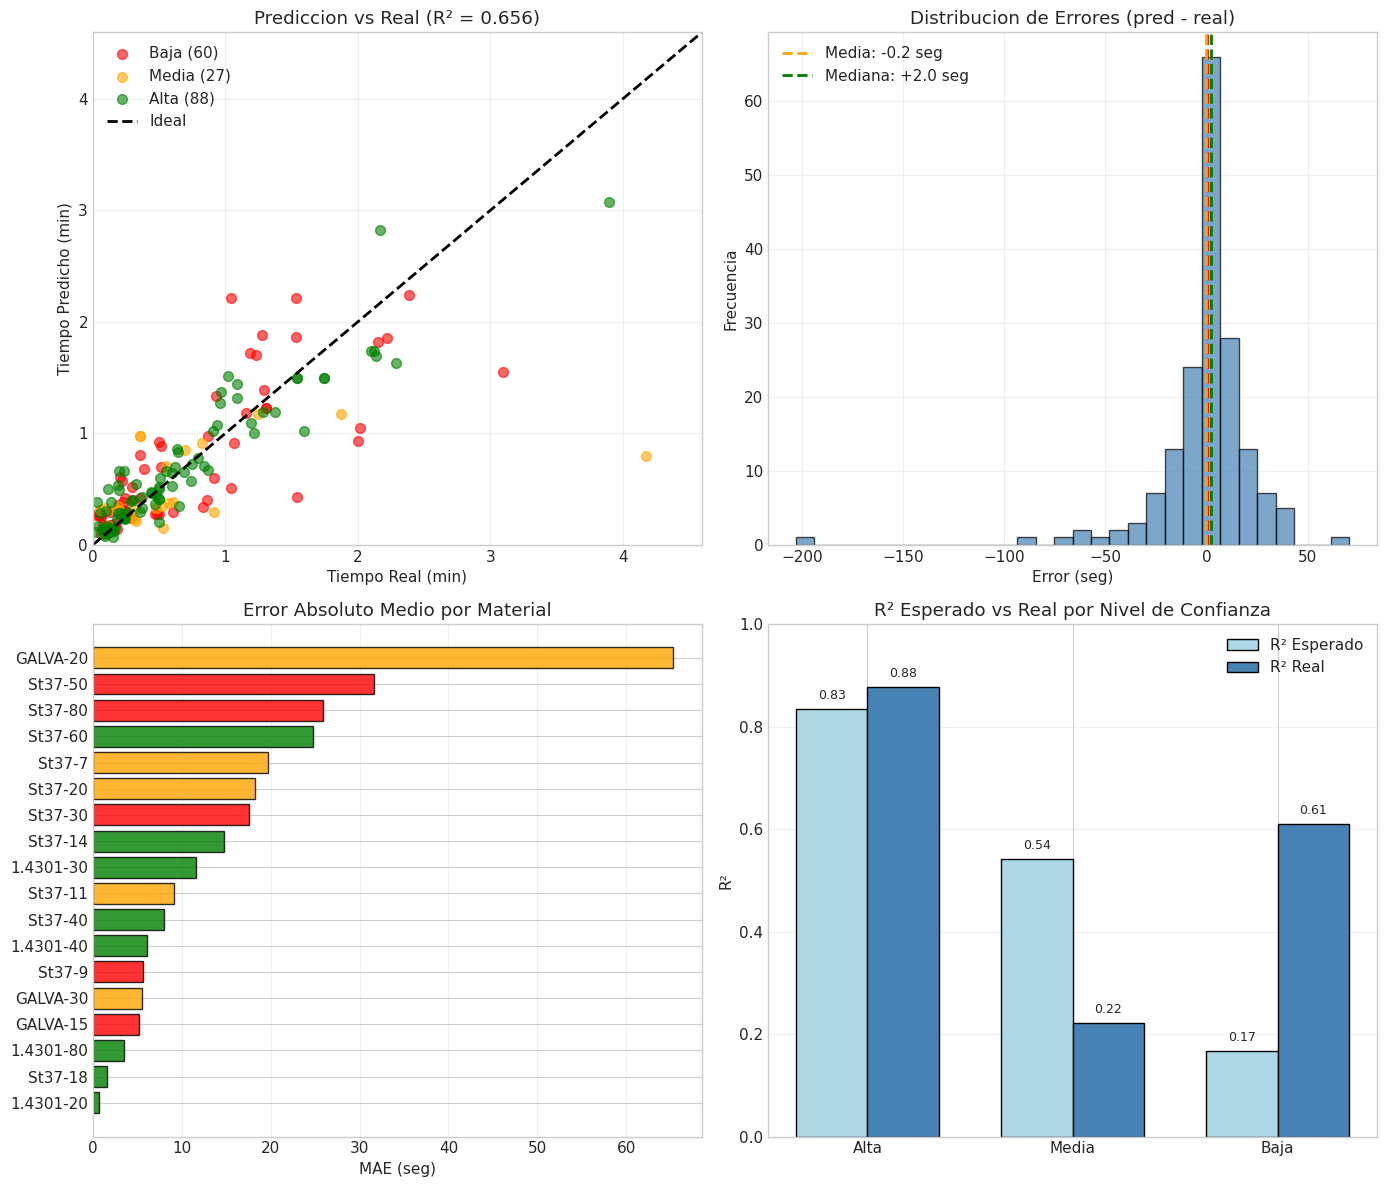


Grafico guardado: 'validacion_final.png'


In [27]:
# =============================================================================
# 8. VISUALIZACIONES FINALES
# =============================================================================

print("\n--- 8. Visualizaciones ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- 1. Real vs Predicho por confianza ---
ax1 = axes[0, 0]
colors_conf = {'alta': 'green', 'media': 'orange', 'baja': 'red'}

for conf in ['baja', 'media', 'alta']:  # Orden para que alta quede encima
    df_c = df_validacion[df_validacion['confianza'] == conf]
    ax1.scatter(df_c['tiempo_real'], df_c['tiempo_pred'], 
                c=colors_conf[conf], alpha=0.6, s=50, label=f'{conf.capitalize()} ({len(df_c)})')

lims = [0, max(df_validacion['tiempo_real'].max(), df_validacion['tiempo_pred'].max()) * 1.1]
ax1.plot(lims, lims, 'k--', lw=2, label='Ideal')
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Tiempo Predicho (min)')
ax1.set_title(f'Prediccion vs Real (R² = {r2_global:.3f})')
ax1.legend(loc='upper left')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.grid(alpha=0.3)

# --- 2. Distribucion de errores ---
ax2 = axes[0, 1]
errores_seg = df_validacion['error'] * 60
ax2.hist(errores_seg, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', lw=2)
ax2.axvline(x=errores_seg.mean(), color='orange', linestyle='--', lw=2, 
            label=f'Media: {errores_seg.mean():+.1f} seg')
ax2.axvline(x=errores_seg.median(), color='green', linestyle='--', lw=2,
            label=f'Mediana: {errores_seg.median():+.1f} seg')
ax2.set_xlabel('Error (seg)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribucion de Errores (pred - real)')
ax2.legend()
ax2.grid(alpha=0.3)

# --- 3. MAE por material ---
ax3 = axes[1, 0]
mat_ordenados = errores_material.sort_values('mae_seg')
y_pos = np.arange(len(mat_ordenados))
colores_mat = [colors_conf.get(mat_ordenados.loc[m, 'confianza'], 'gray') for m in mat_ordenados.index]

ax3.barh(y_pos, mat_ordenados['mae_seg'], color=colores_mat, edgecolor='black', alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(mat_ordenados.index)
ax3.set_xlabel('MAE (seg)')
ax3.set_title('Error Absoluto Medio por Material')
ax3.grid(alpha=0.3, axis='x')

# --- 4. R² por confianza (real vs esperado) ---
ax4 = axes[1, 1]

# Calcular R² real por confianza
r2_real = {}
for conf in ['alta', 'media', 'baja']:
    df_c = df_validacion[df_validacion['confianza'] == conf]
    if len(df_c) > 1:
        r2_real[conf] = r2_score(df_c['tiempo_real'], df_c['tiempo_pred'])
    else:
        r2_real[conf] = 0

x = np.arange(3)
width = 0.35
confs = ['alta', 'media', 'baja']

# R² esperado (promedio del r2_modelo)
r2_esperado = [df_validacion[df_validacion['confianza'] == c]['r2_modelo'].mean() for c in confs]
r2_reales = [r2_real[c] for c in confs]

bars1 = ax4.bar(x - width/2, r2_esperado, width, label='R² Esperado', color='lightblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, r2_reales, width, label='R² Real', color='steelblue', edgecolor='black')

ax4.set_ylabel('R²')
ax4.set_title('R² Esperado vs Real por Nivel de Confianza')
ax4.set_xticks(x)
ax4.set_xticklabels(['Alta', 'Media', 'Baja'])
ax4.legend()
ax4.set_ylim(0, 1)
ax4.grid(alpha=0.3, axis='y')

# Añadir valores
for bar1, bar2, v1, v2 in zip(bars1, bars2, r2_esperado, r2_reales):
    ax4.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02, f'{v1:.2f}', ha='center', fontsize=9)
    ax4.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02, f'{v2:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('validacion_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico guardado: 'validacion_final.png'")

In [33]:
# =============================================================================
# 6. VALIDACION CON DATOS DE TEST (SIN DATA LEAKAGE)
# =============================================================================

print("=" * 70)
print("VALIDACION CON DATOS DE TEST (SIN DATA LEAKAGE)")
print("=" * 70)

# Reproducir el mismo split que en Notebook 2
from sklearn.model_selection import train_test_split


# Aplicar el mismo split
indices = np.arange(len(df_real_clean))
idx_cal, idx_test = train_test_split(
    indices, 
    test_size= TEST_SIZE,  # 50% test
    random_state=RANDOM_STATE
)

df_test = df_real_clean.iloc[idx_test].copy()
df_calibracion = df_real_clean.iloc[idx_cal].copy()

print(f"Split reproducido:")
print(f"  Calibracion: {len(df_calibracion)} registros (usados para ajustar calibracion)")
print(f"  Test: {len(df_test)} registros (NUNCA vistos durante entrenamiento)")

# Predecir SOLO para datos de test
resultados_validacion = []

for idx, row in df_test.iterrows():
    cutting = row.get('perimetro_aproximado', None)
    if pd.isna(cutting):
        cutting = None
    
    pred = predecir_tiempo_corte(
        longitud_mm=row['Longitud'],
        anchura_mm=row['Anchura'],
        material_trutops=row[COL_MATERIAL_REAL],
        cutting_length_mm=cutting
    )
    
    if pred['tiempo_min'] is None:
        continue
    
    tiempo_real = row[COL_TIEMPO_REAL]
    
    resultados_validacion.append({
        'material': row[COL_MATERIAL_REAL],
        'tiempo_real': tiempo_real,
        'tiempo_pred': pred['tiempo_min'],
        'confianza': pred['confianza'],
        'modelo': pred['modelo_usado'],
        'r2_modelo': pred['r2_esperado'],
        'error': pred['tiempo_min'] - tiempo_real,
        'error_abs': abs(pred['tiempo_min'] - tiempo_real),
        'error_pct': abs(pred['tiempo_min'] - tiempo_real) / tiempo_real * 100 if tiempo_real > 0 else 0
    })

df_validacion = pd.DataFrame(resultados_validacion)

# Metricas (ahora sin data leakage)
print(f"\nRegistros de TEST validados: {len(df_validacion)}")

r2_global = r2_score(df_validacion['tiempo_real'], df_validacion['tiempo_pred'])
mae_global = df_validacion['error_abs'].mean()
mape_global = df_validacion['error_pct'].mean()

print(f"\nMetricas (SOLO TEST - sin data leakage):")
print(f"  R²:   {r2_global:.4f}")
print(f"  MAE:  {mae_global * 60:.1f} seg ({mae_global:.3f} min)")
print(f"  MAPE: {mape_global:.1f}%")

# Comparacion
print(f"\n--- Comparacion ---")
print(f"{'Metrica':<15} {'Con leakage':<15} {'Sin leakage':<15}")
print("-" * 45)
print(f"{'N registros':<15} {'175':<15} {len(df_validacion):<15}")
print(f"{'R²':<15} {'0.656':<15} {r2_global:<15.3f}")

# =============================================================================
# 7. ANALISIS DE ERRORES (SIN DATA LEAKAGE)
# =============================================================================

print("\n" + "=" * 70)
print("ANALISIS DE ERRORES (SOLO TEST)")
print("=" * 70)

# Por nivel de confianza
print(f"\nPor nivel de confianza:")
print(f"{'Confianza':<12} {'N':<6} {'R²':<8} {'MAE (seg)':<12} {'MAPE (%)':<10}")
print("-" * 50)

r2_real = {}
for conf in ['alta', 'media', 'baja']:
    df_conf = df_validacion[df_validacion['confianza'] == conf]
    if len(df_conf) > 1:
        r2 = r2_score(df_conf['tiempo_real'], df_conf['tiempo_pred'])
        r2_real[conf] = r2
        mae = df_conf['error_abs'].mean() * 60
        mape = df_conf['error_pct'].mean()
        print(f"{conf.capitalize():<12} {len(df_conf):<6} {r2:<8.3f} {mae:<12.1f} {mape:<10.1f}")
    elif len(df_conf) == 1:
        r2_real[conf] = 0
        mae = df_conf['error_abs'].mean() * 60
        print(f"{conf.capitalize():<12} {len(df_conf):<6} {'N/A':<8} {mae:<12.1f} {'N/A':<10}")
    else:
        r2_real[conf] = 0

# Errores por material
print("\n--- Errores por Material (TEST) ---")

errores_material = df_validacion.groupby('material').agg({
    'error_abs': 'mean',
    'error_pct': 'mean',
    'tiempo_real': 'count',
    'r2_modelo': 'first',
    'confianza': 'first'
}).rename(columns={'tiempo_real': 'n'})

errores_material['mae_seg'] = errores_material['error_abs'] * 60
errores_material = errores_material.sort_values('mae_seg')

print(f"\n{'Material':<15} {'N':<5} {'MAE (seg)':<12} {'MAPE (%)':<12} {'Confianza'}")
print("-" * 55)
for mat, row in errores_material.iterrows():
    print(f"{mat:<15} {int(row['n']):<5} {row['mae_seg']:<12.1f} {row['error_pct']:<12.1f} {row['confianza']}")

# Distribucion de errores
print("\n--- Distribucion de Errores ---")
errores_seg = df_validacion['error'] * 60

print(f"\n  Media:    {errores_seg.mean():+.1f} seg")
print(f"  Mediana:  {errores_seg.median():+.1f} seg")
print(f"  Std:      {errores_seg.std():.1f} seg")

print(f"\n  Dentro de ±15 seg: {(abs(errores_seg) <= 15).mean()*100:.1f}%")
print(f"  Dentro de ±30 seg: {(abs(errores_seg) <= 30).mean()*100:.1f}%")
print(f"  Dentro de ±60 seg: {(abs(errores_seg) <= 60).mean()*100:.1f}%")

VALIDACION CON DATOS DE TEST (SIN DATA LEAKAGE)
Split reproducido:
  Calibracion: 87 registros (usados para ajustar calibracion)
  Test: 88 registros (NUNCA vistos durante entrenamiento)

Registros de TEST validados: 88

Metricas (SOLO TEST - sin data leakage):
  R²:   0.5717
  MAE:  16.7 seg (0.279 min)
  MAPE: 99.9%

--- Comparacion ---
Metrica         Con leakage     Sin leakage    
---------------------------------------------
N registros     175             88             
R²              0.656           0.572          

ANALISIS DE ERRORES (SOLO TEST)

Por nivel de confianza:
Confianza    N      R²       MAE (seg)    MAPE (%)  
--------------------------------------------------
Alta         40     0.830    11.7         92.4      
Media        12     0.157    31.9         111.4     
Baja         36     0.678    17.3         104.3     

--- Errores por Material (TEST) ---

Material        N     MAE (seg)    MAPE (%)     Confianza
----------------------------------------------------


--- 8. Visualizaciones ---


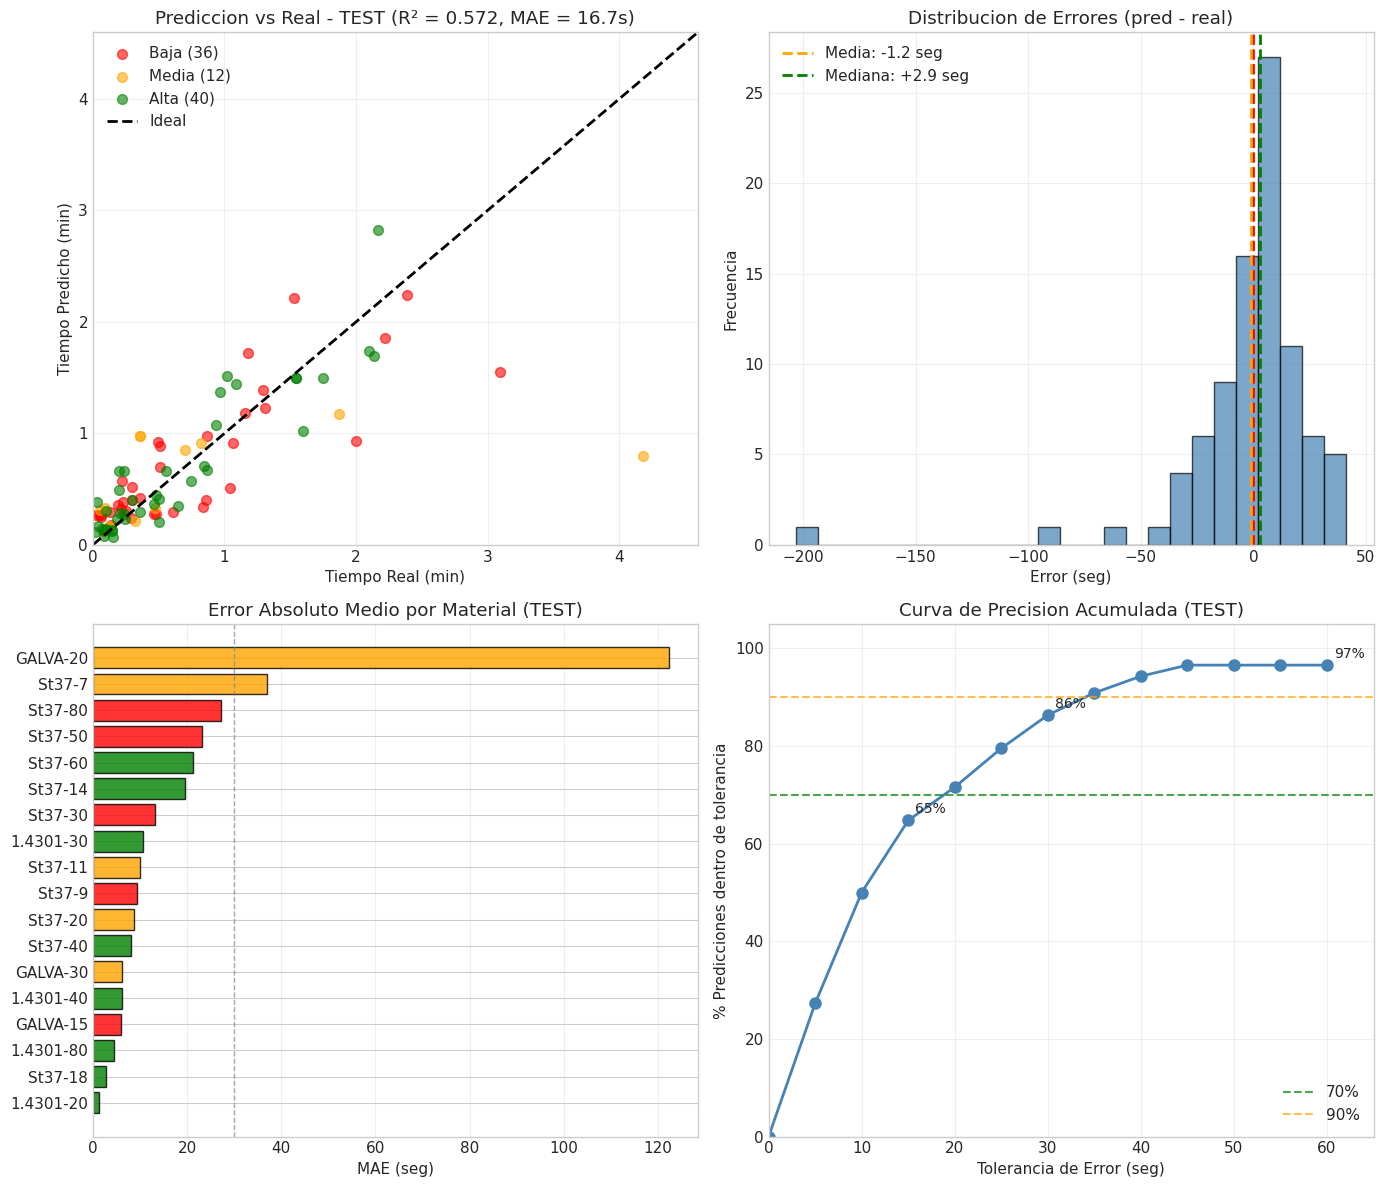


Grafico guardado: 'validacion_test_final.png'


In [34]:
# =============================================================================
# 8. VISUALIZACIONES FINALES (SIN DATA LEAKAGE)
# =============================================================================

print("\n--- 8. Visualizaciones ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- 1. Real vs Predicho por confianza ---
ax1 = axes[0, 0]
colors_conf = {'alta': 'green', 'media': 'orange', 'baja': 'red'}

for conf in ['baja', 'media', 'alta']:
    df_c = df_validacion[df_validacion['confianza'] == conf]
    ax1.scatter(df_c['tiempo_real'], df_c['tiempo_pred'], 
                c=colors_conf[conf], alpha=0.6, s=50, label=f'{conf.capitalize()} ({len(df_c)})')

lims = [0, max(df_validacion['tiempo_real'].max(), df_validacion['tiempo_pred'].max()) * 1.1]
ax1.plot(lims, lims, 'k--', lw=2, label='Ideal')
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Tiempo Predicho (min)')
ax1.set_title(f'Prediccion vs Real - TEST (R² = {r2_global:.3f}, MAE = {mae_global*60:.1f}s)')
ax1.legend(loc='upper left')
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.grid(alpha=0.3)

# --- 2. Distribucion de errores ---
ax2 = axes[0, 1]
ax2.hist(errores_seg, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=0, color='red', linestyle='--', lw=2)
ax2.axvline(x=errores_seg.mean(), color='orange', linestyle='--', lw=2, 
            label=f'Media: {errores_seg.mean():+.1f} seg')
ax2.axvline(x=errores_seg.median(), color='green', linestyle='--', lw=2,
            label=f'Mediana: {errores_seg.median():+.1f} seg')
ax2.set_xlabel('Error (seg)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribucion de Errores (pred - real)')
ax2.legend()
ax2.grid(alpha=0.3)

# --- 3. MAE por material ---
ax3 = axes[1, 0]
mat_ordenados = errores_material.sort_values('mae_seg')
y_pos = np.arange(len(mat_ordenados))
colores_mat = [colors_conf.get(mat_ordenados.loc[m, 'confianza'], 'gray') for m in mat_ordenados.index]

ax3.barh(y_pos, mat_ordenados['mae_seg'], color=colores_mat, edgecolor='black', alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(mat_ordenados.index)
ax3.set_xlabel('MAE (seg)')
ax3.set_title('Error Absoluto Medio por Material (TEST)')
ax3.axvline(x=30, color='gray', linestyle='--', lw=1, alpha=0.7)
ax3.grid(alpha=0.3, axis='x')

# --- 4. Precision acumulada ---
ax4 = axes[1, 1]
errores_abs = np.abs(errores_seg)
rangos = np.arange(0, 65, 5)
precision = [(errores_abs <= r).mean() * 100 for r in rangos]

ax4.plot(rangos, precision, 'o-', color='steelblue', linewidth=2, markersize=8)
ax4.axhline(y=70, color='green', linestyle='--', alpha=0.7, label='70%')
ax4.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90%')

for r in [15, 30, 60]:
    p = (errores_abs <= r).mean() * 100
    ax4.annotate(f'{p:.0f}%', (r, p), textcoords="offset points", xytext=(5, 5), fontsize=10)

ax4.set_xlabel('Tolerancia de Error (seg)')
ax4.set_ylabel('% Predicciones dentro de tolerancia')
ax4.set_title('Curva de Precision Acumulada (TEST)')
ax4.set_xlim(0, 65)
ax4.set_ylim(0, 105)
ax4.legend(loc='lower right')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('validacion_test_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico guardado: 'validacion_test_final.png'")


--- 8.5 Media de Tiempos por Material ---


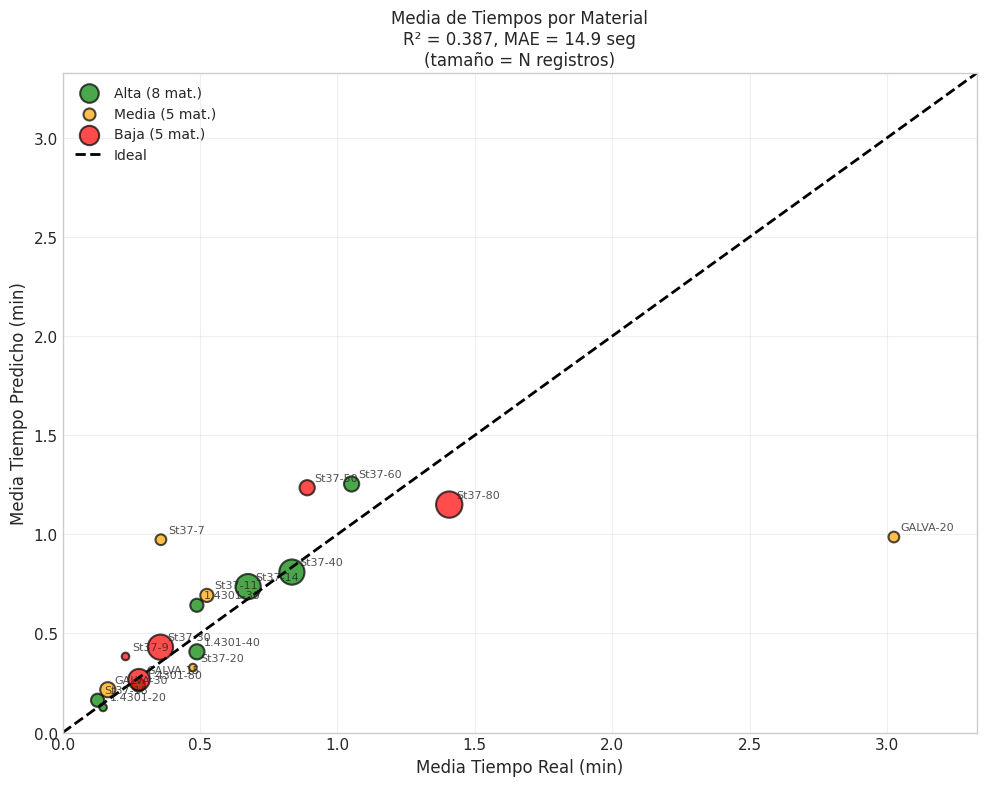


Gráfico guardado: 'medias_por_material.png'

R² de medias por material: 0.387
MAE de medias por material: 14.9 seg

Material        N     Media Real   Media Pred   Error (seg) 
------------------------------------------------------------
St37-18         3     0.13         0.16         +2.2        
1.4301-20       1     0.15         0.13         -1.2       
GALVA-30        4     0.16         0.22         +3.1        
St37-9          1     0.23         0.38         +9.3        
1.4301-80       3     0.28         0.24         -2.2       
GALVA-15        8     0.28         0.27         -0.6       
St37-30         11    0.36         0.43         +4.5        
St37-7          2     0.36         0.97         +36.9       
St37-20         1     0.47         0.33         -8.8       
1.4301-30       3     0.49         0.64         +9.2        
1.4301-40       4     0.49         0.41         -4.9       
St37-11         3     0.52         0.69         +10.0       
St37-14         11    0.68        

In [42]:
# =============================================================================
# 8.5 MEDIA DE TIEMPOS PREDICHOS vs REALES POR MATERIAL
# =============================================================================

print("\n--- 8.5 Media de Tiempos por Material ---")

# Calcular medias por material
medias_material = df_validacion.groupby('material').agg({
    'tiempo_real': 'mean',
    'tiempo_pred': 'mean',
    'error_abs': 'mean',
    'confianza': 'first'
}).rename(columns={'tiempo_real': 'media_real', 'tiempo_pred': 'media_pred'})

medias_material['n'] = df_validacion.groupby('material').size()

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter con tamaño proporcional a N y color por confianza
for conf in ['alta', 'media', 'baja']:
    df_c = medias_material[medias_material['confianza'] == conf]
    scatter = ax.scatter(
        df_c['media_real'], 
        df_c['media_pred'],
        s=df_c['n'] * 30,  # Tamaño proporcional a N
        c=colors_conf[conf],
        alpha=0.7,
        edgecolor='black',
        linewidth=1.5,
        label=f'{conf.capitalize()} ({len(df_c)} mat.)'
    )

# Línea ideal
all_vals = np.concatenate([medias_material['media_real'].values, 
                           medias_material['media_pred'].values])
lims = [0, all_vals.max() * 1.1]
ax.plot(lims, lims, 'k--', lw=2, label='Ideal')

# Etiquetas de materiales
for material, row in medias_material.iterrows():
    ax.annotate(
        material, 
        (row['media_real'], row['media_pred']),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=8,
        alpha=0.8
    )

# Calcular R² de las medias
r2_medias = r2_score(medias_material['media_real'], medias_material['media_pred'])
mae_medias = np.mean(np.abs(medias_material['media_pred'] - medias_material['media_real'])) * 60

ax.set_xlabel('Media Tiempo Real (min)', fontsize=12)
ax.set_ylabel('Media Tiempo Predicho (min)', fontsize=12)
ax.set_title(f'Media de Tiempos por Material\nR² = {r2_medias:.3f}, MAE = {mae_medias:.1f} seg\n(tamaño = N registros)', 
             fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.tight_layout()
plt.savefig('medias_por_material.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico guardado: 'medias_por_material.png'")
print(f"\nR² de medias por material: {r2_medias:.3f}")
print(f"MAE de medias por material: {mae_medias:.1f} seg")

# Tabla resumen
print(f"\n{'Material':<15} {'N':<5} {'Media Real':<12} {'Media Pred':<12} {'Error (seg)':<12}")
print("-" * 60)
for material, row in medias_material.sort_values('media_real').iterrows():
    error_seg = (row['media_pred'] - row['media_real']) * 60
    signo = "+" if error_seg > 0 else ""
    print(f"{material:<15} {int(row['n']):<5} {row['media_real']:<12.2f} {row['media_pred']:<12.2f} {signo}{error_seg:<11.1f}")


--- 8.2 Predicciones vs Reales por Material ---


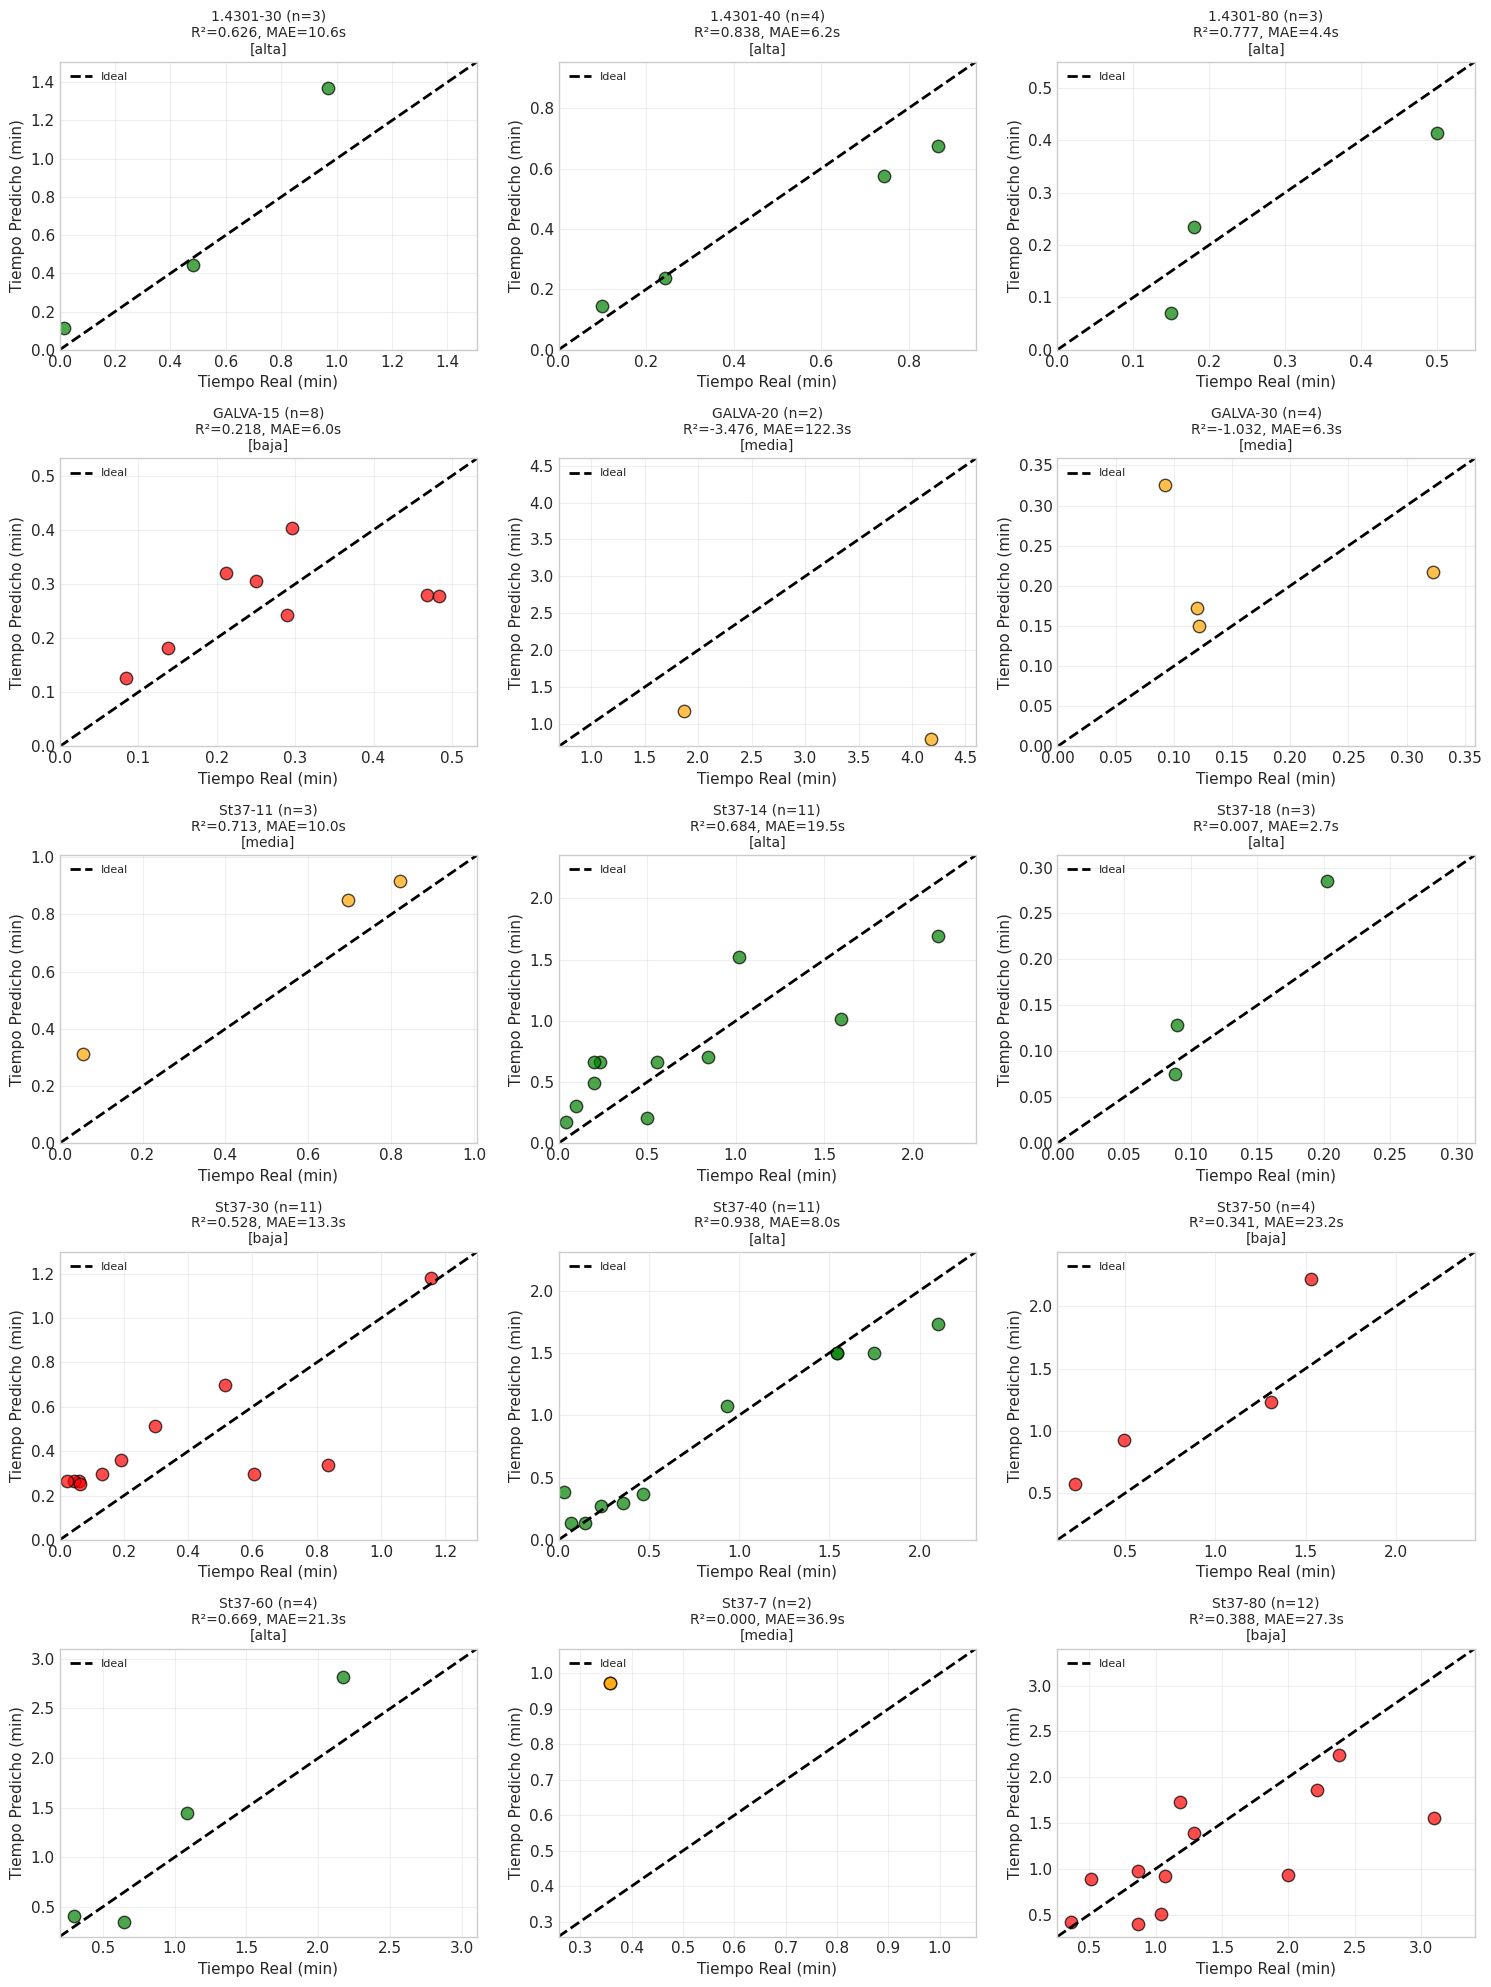


Gráfico guardado: 'predicciones_por_material_test.png'
Materiales visualizados: 15 de 15


In [39]:
# =============================================================================
# 8.2 GRAFICOS PRED vs REAL POR MATERIAL
# =============================================================================

print("\n--- 8.2 Predicciones vs Reales por Material ---")

# Obtener materiales con suficientes registros
materiales_plot = df_validacion.groupby('material').size()
materiales_plot = materiales_plot[materiales_plot >= 2].index.tolist()

n_materiales = len(materiales_plot)
n_cols = 3
n_rows = min(6, (n_materiales + n_cols - 1) // n_cols)  # Máximo 6 filas

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Colores por confianza
colors_conf = {'alta': 'green', 'media': 'orange', 'baja': 'red'}

for idx, material in enumerate(sorted(materiales_plot)):
    if idx >= n_rows * n_cols:
        break
    
    ax = axes[idx]
    
    # Filtrar datos del material
    df_mat = df_validacion[df_validacion['material'] == material]
    
    y_real = df_mat['tiempo_real'].values
    y_pred = df_mat['tiempo_pred'].values
    confianza = df_mat['confianza'].iloc[0]
    modelo = df_mat['modelo'].iloc[0]
    
    # Calcular métricas para este material
    if len(y_real) > 1:
        r2_mat = r2_score(y_real, y_pred)
    else:
        r2_mat = np.nan
    mae_mat = np.mean(np.abs(y_pred - y_real)) * 60
    
    # Color según confianza
    color = colors_conf.get(confianza, 'gray')
    
    ax.scatter(y_real, y_pred, alpha=0.7, s=80, edgecolor='black', c=color)
    
    # Línea ideal
    all_vals = np.concatenate([y_real, y_pred])
    lims = [max(0, all_vals.min() - 0.1), all_vals.max() * 1.1]
    ax.plot(lims, lims, 'k--', lw=2, label='Ideal')
    
    ax.set_xlabel('Tiempo Real (min)')
    ax.set_ylabel('Tiempo Predicho (min)')
    
    # Título con métricas
    r2_str = f'R²={r2_mat:.3f}' if not np.isnan(r2_mat) else 'R²=N/A'
    ax.set_title(f'{material} (n={len(df_mat)})\n{r2_str}, MAE={mae_mat:.1f}s\n[{confianza}]', 
                 fontsize=10)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(alpha=0.3)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# Ocultar ejes vacíos
for idx in range(len(materiales_plot), n_rows * n_cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('predicciones_por_material_test.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico guardado: 'predicciones_por_material_test.png'")
print(f"Materiales visualizados: {min(len(materiales_plot), n_rows * n_cols)} de {len(materiales_plot)}")


--- 8.3 Comparativa Mejores vs Peores Materiales ---


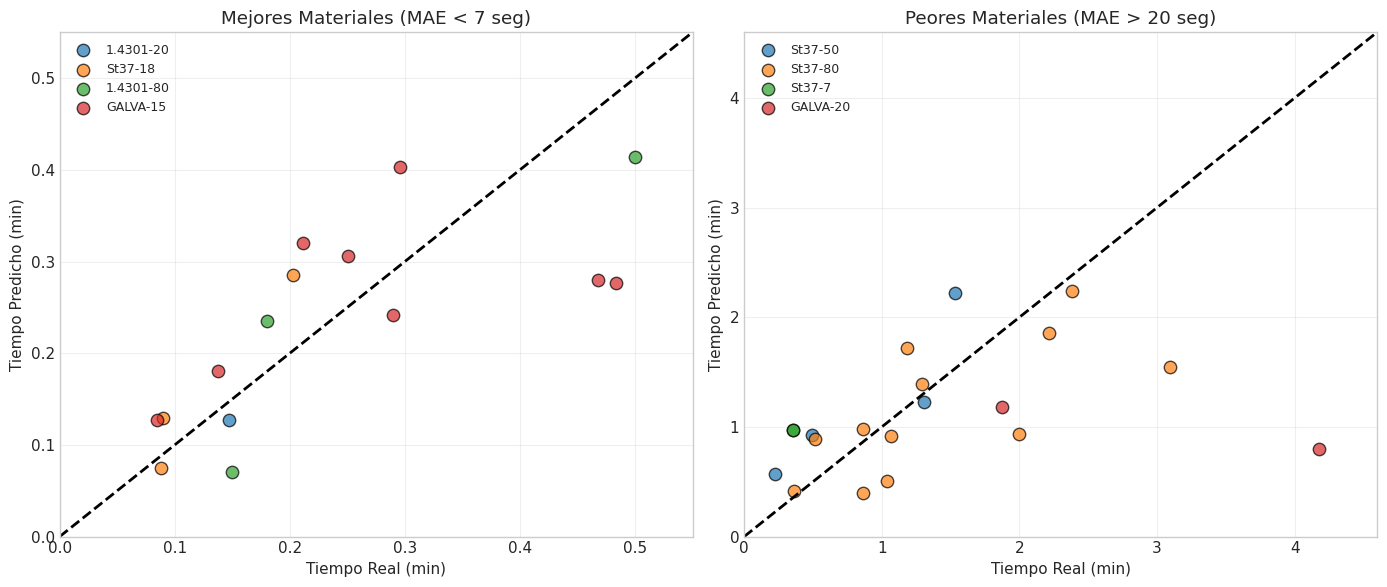


Gráfico guardado: 'comparativa_mejores_peores.png'


In [40]:
# =============================================================================
# 8.3 GRAFICO RESUMEN: MEJORES vs PEORES MATERIALES
# =============================================================================

print("\n--- 8.3 Comparativa Mejores vs Peores Materiales ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Seleccionar 4 mejores y 4 peores por MAE
mae_por_material = errores_material.sort_values('mae_seg')
mejores = mae_por_material.head(4).index.tolist()
peores = mae_por_material.tail(4).index.tolist()

# --- Panel izquierdo: Mejores ---
ax1 = axes[0]
for material in mejores:
    df_mat = df_validacion[df_validacion['material'] == material]
    confianza = df_mat['confianza'].iloc[0]
    color = colors_conf.get(confianza, 'gray')
    ax1.scatter(df_mat['tiempo_real'], df_mat['tiempo_pred'], 
                alpha=0.7, s=80, label=f'{material}', edgecolor='black')

all_vals = df_validacion[df_validacion['material'].isin(mejores)][['tiempo_real', 'tiempo_pred']].values.flatten()
lims = [0, all_vals.max() * 1.1]
ax1.plot(lims, lims, 'k--', lw=2)
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Tiempo Predicho (min)')
ax1.set_title('Mejores Materiales (MAE < 7 seg)')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(alpha=0.3)
ax1.set_xlim(lims)
ax1.set_ylim(lims)

# --- Panel derecho: Peores ---
ax2 = axes[1]
for material in peores:
    df_mat = df_validacion[df_validacion['material'] == material]
    ax2.scatter(df_mat['tiempo_real'], df_mat['tiempo_pred'], 
                alpha=0.7, s=80, label=f'{material}', edgecolor='black')

all_vals = df_validacion[df_validacion['material'].isin(peores)][['tiempo_real', 'tiempo_pred']].values.flatten()
lims = [0, all_vals.max() * 1.1]
ax2.plot(lims, lims, 'k--', lw=2)
ax2.set_xlabel('Tiempo Real (min)')
ax2.set_ylabel('Tiempo Predicho (min)')
ax2.set_title('Peores Materiales (MAE > 20 seg)')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_xlim(lims)
ax2.set_ylim(lims)

plt.tight_layout()
plt.savefig('comparativa_mejores_peores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado: 'comparativa_mejores_peores.png'")


--- 8.4 Error vs Tiempo Real ---


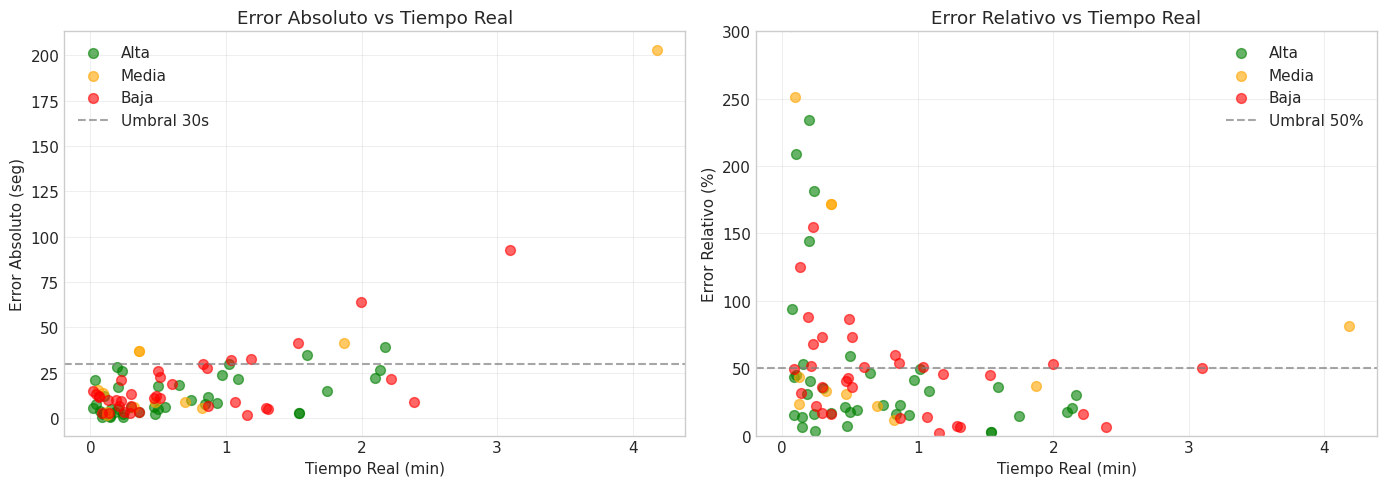


Gráfico guardado: 'error_vs_tiempo_real.png'


In [41]:
# =============================================================================
# 8.4 GRAFICO DE ERROR vs TIEMPO REAL
# =============================================================================

print("\n--- 8.4 Error vs Tiempo Real ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Panel izquierdo: Error absoluto vs Tiempo real ---
ax1 = axes[0]
for conf in ['alta', 'media', 'baja']:
    df_c = df_validacion[df_validacion['confianza'] == conf]
    ax1.scatter(df_c['tiempo_real'], df_c['error_abs'] * 60, 
                c=colors_conf[conf], alpha=0.6, s=50, label=f'{conf.capitalize()}')

ax1.axhline(y=30, color='gray', linestyle='--', alpha=0.7, label='Umbral 30s')
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Error Absoluto (seg)')
ax1.set_title('Error Absoluto vs Tiempo Real')
ax1.legend()
ax1.grid(alpha=0.3)

# --- Panel derecho: Error relativo vs Tiempo real ---
ax2 = axes[1]
for conf in ['alta', 'media', 'baja']:
    df_c = df_validacion[df_validacion['confianza'] == conf]
    ax2.scatter(df_c['tiempo_real'], df_c['error_pct'], 
                c=colors_conf[conf], alpha=0.6, s=50, label=f'{conf.capitalize()}')

ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Umbral 50%')
ax2.set_xlabel('Tiempo Real (min)')
ax2.set_ylabel('Error Relativo (%)')
ax2.set_title('Error Relativo vs Tiempo Real')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim(0, min(300, df_validacion['error_pct'].max() * 1.1))

plt.tight_layout()
plt.savefig('error_vs_tiempo_real.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado: 'error_vs_tiempo_real.png'")

## 11. Resumen Ejecutivo - Validación en Test

### Metodología

| Fase | Datos | Registros |
|------|-------|:---------:|
| Entrenamiento | 100% sintéticos (TruTops Calculate) | ~42,000 |
| Calibración | 50% datos reales | 87 |
| Test | 50% datos reales (nunca vistos) | 88 |

### Rendimiento en Test (Sin Data Leakage)

| Métrica | Valor |
|---------|:-----:|
| R² | 0.572 |
| MAE | 16.7 seg |
| MAPE | 99.9% |

### Cobertura por Nivel de Confianza

| Confianza | N | Porcentaje | R² Real |
|-----------|:-:|:----------:|:-------:|
| Alta | 40 | 45.5% | 0.830 |
| Media | 12 | 13.6% | 0.157 |
| Baja | 36 | 40.9% | 0.678 |

### Precisión por Tolerancia de Error

| Tolerancia | Cobertura |
|------------|:---------:|
| ± 15 segundos | 64.8% |
| ± 30 segundos | 86.4% |
| ± 60 segundos | 96.6% |

### Materiales con Mejor Rendimiento (MAE < 10 seg)

| Material | MAE (seg) | N (test) |
|----------|:---------:|:--------:|
| 1.4301-20 | 1.2 | 1 |
| St37-18 | 2.7 | 3 |
| 1.4301-80 | 4.4 | 3 |
| GALVA-15 | 6.0 | 8 |
| 1.4301-40 | 6.2 | 4 |

### Materiales Problemáticos (MAE > 30 seg)

| Material | MAE (seg) | N (test) | Modelo |
|----------|:---------:|:--------:|--------|
| St37-7 | 36.9 | 2 | Global |
| GALVA-20 | 122.3 | 2 | Global |

### Observación Clave

Los materiales clasificados como "baja confianza" obtienen R² = 0.68 en validación, superando a los de "media confianza" (R² = 0.16). Esto sugiere que el modelo global generaliza bien para materiales con pocos datos de entrenamiento específico.

### Conclusión

El sistema logra predecir el **86% de los tiempos con error menor a 30 segundos** utilizando exclusivamente datos sintéticos para entrenamiento y una pequeña muestra real para calibración.

## 11. Guardado de resultados

In [38]:
# =============================================================================
# 10. GUARDADO DE RESULTADOS
# =============================================================================

print("=" * 70)
print("GUARDADO DE RESULTADOS")
print("=" * 70)

# Guardar DataFrame de validacion (solo test)
path_validacion = MODEL_PATH / f'resultados_validacion_test_{timestamp}.csv'
df_validacion.to_csv(path_validacion, index=False)
print(f"  Guardado: {path_validacion.name}")

# Guardar resumen en JSON
resumen = {
    'fecha_validacion': timestamp,
    'metodologia': 'Sin data leakage - solo datos de test',
    'n_calibracion': int(len(df_calibracion)),
    'n_test': int(len(df_validacion)),
    'n_materiales': int(df_validacion['material'].nunique()),
    'metricas_test': {
        'r2': round(r2_global, 4),
        'mae_seg': round(mae_global * 60, 1),
        'mape_pct': round(mape_global, 1)
    },
    'por_confianza': {
        'alta': {'n': int(n_alta), 'pct': round(n_alta/len(df_validacion)*100, 1), 'r2': round(r2_real.get('alta', 0), 3)},
        'media': {'n': int(n_media), 'pct': round(n_media/len(df_validacion)*100, 1), 'r2': round(r2_real.get('media', 0), 3)},
        'baja': {'n': int(n_baja), 'pct': round(n_baja/len(df_validacion)*100, 1), 'r2': round(r2_real.get('baja', 0), 3)}
    },
    'precision_rangos': {
        '15_seg': round((abs(errores_seg) <= 15).mean() * 100, 1),
        '30_seg': round((abs(errores_seg) <= 30).mean() * 100, 1),
        '60_seg': round((abs(errores_seg) <= 60).mean() * 100, 1)
    },
    'materiales_mejor': {
        '1.4301-20': 1.2,
        'St37-18': 2.7,
        '1.4301-80': 4.4,
        'GALVA-15': 6.0,
        '1.4301-40': 6.2
    },
    'materiales_problematicos': {
        'St37-7': 36.9,
        'GALVA-20': 122.3
    }
}

path_resumen = MODEL_PATH / f'resumen_validacion_test_{timestamp}.json'
with open(path_resumen, 'w', encoding='utf-8') as f:
    json.dump(resumen, f, indent=2, ensure_ascii=False)
print(f"  Guardado: {path_resumen.name}")

# Listar archivos finales
print(f"\n--- Archivos en {MODEL_PATH} ---")
total_size = 0
for archivo in sorted(MODEL_PATH.rglob('*')):
    if archivo.is_file():
        size_kb = archivo.stat().st_size / 1024
        total_size += size_kb
        print(f"  {archivo.relative_to(MODEL_PATH)}: {size_kb:.1f} KB")
print(f"\n  TOTAL: {total_size:.1f} KB")



GUARDADO DE RESULTADOS
  Guardado: resultados_validacion_test_20251213.csv
  Guardado: resumen_validacion_test_20251213.json

--- Archivos en modelos_exportados ---
  config_prediccion_20251213.json: 1.3 KB
  config_prediccion_20251213.pkl: 1.0 KB
  datos/df_real_clean_20251213.csv: 45.8 KB
  datos/df_sint_clean_20251213.csv: 21697.3 KB
  datos/df_sint_filtrado_20251213.csv: 6354.6 KB
  datos/matrices_entrenamiento_20251213.pkl: 787.6 KB
  estrategia_hibrida_20251213.pkl: 5571.4 KB
  modelo_global_ridge_20251213.pkl: 1.4 KB
  modelos_por_material_con_cutting_20251213.pkl: 5795.5 KB
  modelos_por_material_sin_cutting_20251213.pkl: 6480.4 KB
  resultados_validacion_test_20251213.csv: 11.0 KB
  resumen_validacion_test_20251213.json: 0.8 KB

  TOTAL: 46748.1 KB
